# Capstone Project Modelling

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression #C is regularization param
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn import discriminant_analysis
from sklearn import naive_bayes

### Get Data and Train-Test-Split

In [2]:
from ticket_prediction_data import Ticket_PredictionData

tixO = Ticket_PredictionData()

Connection working!


In [3]:
X_train, X_test, y_train, y_test = tixO.get_data()

Querying for main table
Got main table
Simplifying venues
Venues simplified
Simplifying events
Events simplified
Simplifying zones
Zones simplified
Querying for performers
Dummying performers
Performers dummied
Concatenating dummied performers
Performers concatanated
Starting final cleanup
Done


In [4]:
print('0 vs 1 counts: %10d, %10d' %(np.sum(y_train==0), np.sum(y_train==1))) #
print('0 vs 1 percentages: %10.3f, %10.3f' %(np.sum(y_train==0) / y_train.shape[0], np.sum(y_train==1) / y_train.shape[0])) 

0 vs 1 counts:      81386,       9229
0 vs 1 percentages:      0.898,      0.102


##### Minority class situation!  Will need to address throughout model training.

### Logistic Regression w/o Imbalanced Handling

In [5]:
#Training

logistic = LogisticRegression(C=1e5)  # turning off the Ridge regularization

logistic.fit(X_train, y_train)
logistic_pred = logistic.predict(X_train)
logistic_proba = logistic.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, logistic_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, logistic_proba[:,1]))) 
print('Accuracy: %.3f' %(logistic.score(X_train, y_train)))

confusion_matrix:
 [[81198   188]
 [ 9048   181]]
AUC 0.790
Accuracy: 0.898


In [6]:
#Holdout

logistic_predT = logistic.predict(X_test)
logistic_probaT = logistic.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, logistic_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, logistic_probaT[:,1]))) 
print('Accuracy: %.3f' %(logistic.score(X_test, y_test)))

confusion_matrix:
 [[30819   173]
 [ 3614   172]]
AUC 0.708
Accuracy: 0.891


### Logistic Regression Bayesian Rule Decision Boundary

In [7]:
#Training

print('There are %d instances classified into Y=1 (listing not available next day)' %(np.sum(logistic_proba[:,1]>9229/90615)))
print('confusion_matrix:\n', confusion_matrix(y_train, logistic_proba[:,1]>9229/90615)) 
print('AUC %.3f' %(roc_auc_score(y_train, logistic_proba[:,1]>9229/90615))) 
tn, fp, fn, tp = confusion_matrix(y_train, logistic_proba[:,1]>9229/90615).ravel()
print('Accuracy: %.3f' %((tn + tp) / (tn + tp + fn + fp)))

There are 32449 instances classified into Y=1 (listing not available next day)
confusion_matrix:
 [[55990 25396]
 [ 2176  7053]]
AUC 0.726
Accuracy: 0.696


In [8]:
#Holdout

print('There are %d instances classified into Y=1 (listing not available next day)' %(np.sum(logistic_probaT[:,1]>9229/90615)))
print('confusion_matrix:\n', confusion_matrix(y_test, logistic_probaT[:,1]>9229/90615)) 
print('AUC %.3f' %(roc_auc_score(y_test, logistic_probaT[:,1]>9229/90615))) 
tnT, fpT, fnT, tpT = confusion_matrix(y_test, logistic_probaT[:,1]>9229/90615).ravel()
print('Accuracy: %.3f' %((tnT + tpT) / (tnT + tpT + fnT + fpT)))

There are 11867 instances classified into Y=1 (listing not available next day)
confusion_matrix:
 [[21468  9524]
 [ 1443  2343]]
AUC 0.656
Accuracy: 0.685


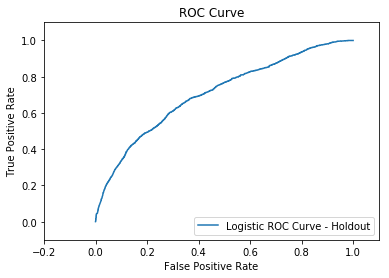

In [12]:
#Draw ROC Curve for balanced vs unbalanced

#scoreA = svm.decision_function(X_test)
#scoreB = svmB.decision_function(X_test)

A=roc_curve(y_test,logistic_probaT[:,1],pos_label=1)
#B=roc_curve(y_test,scoreB,pos_label=0)

plt.plot(A[0],A[1],label='Logistic ROC Curve - Holdout')

plt.xlim((-0.2,1.1))
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.ylim((-0.1,1.1))
plt.title('ROC Curve')
plt.legend(loc=4)

##### Many more classified into minority class at expense of substantial misclassification to majority class.  Let's try lowering decision boundary even further (.075)

In [9]:
#Training

print('There are %d instances classified into Y=1 (listing not available next day)' %(np.sum(logistic_proba[:,1]>.075)))
print('confusion_matrix:\n', confusion_matrix(y_train, logistic_proba[:,1]>.075)) 
print('AUC %.3f' %(roc_auc_score(y_train, logistic_proba[:,1]>.075))) 
tn, fp, fn, tp = confusion_matrix(y_train, logistic_proba[:,1]>.075).ravel()
print('Accuracy: %.3f' %((tn + tp) / (tn + tp + fn + fp)))

There are 39872 instances classified into Y=1 (listing not available next day)
confusion_matrix:
 [[49125 32261]
 [ 1618  7611]]
AUC 0.714
Accuracy: 0.626


In [10]:
#Holdout

print('There are %d instances classified into Y=1 (listing not available next day)' %(np.sum(logistic_probaT[:,1]>.075)))
print('confusion_matrix:\n', confusion_matrix(y_test, logistic_probaT[:,1]>.075)) 
print('AUC %.3f' %(roc_auc_score(y_test, logistic_probaT[:,1]>.075))) 
tnT, fpT, fnT, tpT = confusion_matrix(y_test, logistic_probaT[:,1]>.075).ravel()
print('Accuracy: %.3f' %((tnT + tpT) / (tnT + tpT + fnT + fpT)))

There are 14953 instances classified into Y=1 (listing not available next day)
confusion_matrix:
 [[18657 12335]
 [ 1168  2618]]
AUC 0.647
Accuracy: 0.612


##### We correctly predict ticket listings as being UNAVAILABLE the following day 69% of the time, but only correctly predict tickets being AVAILABLE the following day 60% of the time.

### Logistic Regression Balanced Class Weight

In [11]:
#Training
logBal = LogisticRegression(C=1e5, class_weight = 'balanced')  #balanced class weight, ridge regularization turned off

logBal.fit(X_train, y_train)
logBal_pred = logBal.predict(X_train)
logBal_proba = logBal.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, logBal_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, logBal_proba[:,1]))) 
print('Accuracy: %.3f' %(logBal.score(X_train, y_train)))

confusion_matrix:
 [[56657 24729]
 [ 2097  7132]]
AUC 0.794
Accuracy: 0.704


In [12]:
#Holdout
logBal_predT = logBal.predict(X_test)
logBal_probaT = logBal.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, logBal_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, logBal_probaT[:,1]))) 
print('Accuracy: %.3f' %(logBal.score(X_test, y_test)))

confusion_matrix:
 [[21461  9531]
 [ 1314  2472]]
AUC 0.713
Accuracy: 0.688


In [1]:
21461 / (21461 + 9531)

0.6924690242643263

##### We correctly predict ticket listings as being UNAVAILABLE the following day 65% of the time, but only correctly predict tickets being AVAILABLE the following day 69% of the time.

### Try Lasso Regularization

In [14]:
#Training
logBalLasso = LogisticRegression(class_weight = 'balanced', penalty = 'l1')  #balanced class weight, Lasso regularization

logBalLasso.fit(X_train, y_train)
logBalLasso_pred = logBalLasso.predict(X_train)
logBalLasso_proba = logBalLasso.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, logBalLasso_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, logBalLasso_proba[:,1]))) 
print('Accuracy: %.3f' %(logBalLasso.score(X_train, y_train)))

confusion_matrix:
 [[56698 24688]
 [ 2090  7139]]
AUC 0.794
Accuracy: 0.704


In [15]:
#Holdout
logBalLasso_predT = logBalLasso.predict(X_test)
logBalLasso_probaT = logBalLasso.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, logBalLasso_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, logBalLasso_probaT[:,1]))) 
print('Accuracy: %.3f' %(logBalLasso.score(X_test, y_test)))

confusion_matrix:
 [[21487  9505]
 [ 1322  2464]]
AUC 0.711
Accuracy: 0.689


### Try Ridge Regularization

In [16]:
#Training
logBalRidge = LogisticRegression(class_weight = 'balanced')  #balanced class weight, Ridge regularization defaults

logBalRidge.fit(X_train, y_train)
logBalRidge_pred = logBalRidge.predict(X_train)
logBalRidge_proba = logBalRidge.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, logBalRidge_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, logBalRidge_proba[:,1]))) 
print('Accuracy: %.3f' %(logBalRidge.score(X_train, y_train)))

confusion_matrix:
 [[56541 24845]
 [ 2105  7124]]
AUC 0.793
Accuracy: 0.703


In [17]:
#Holdout
logBalRidge_predT = logBalRidge.predict(X_test)
logBalRidge_probaT = logBalRidge.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, logBalRidge_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, logBalRidge_probaT[:,1]))) 
print('Accuracy: %.3f' %(logBalRidge.score(X_test, y_test)))

confusion_matrix:
 [[21520  9472]
 [ 1323  2463]]
AUC 0.716
Accuracy: 0.690


### Ridge with Unbalanced Class Weight

In [18]:
#Training
logRidge = LogisticRegression()  #balanced class weight, Ridge regularization defaults

logRidge.fit(X_train, y_train)
logRidge_pred = logRidge.predict(X_train)
logRidge_proba = logRidge.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, logRidge_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, logRidge_proba[:,1]))) 
print('Accuracy: %.3f' %(logRidge.score(X_train, y_train)))

confusion_matrix:
 [[81152   234]
 [ 9032   197]]
AUC 0.790
Accuracy: 0.898


In [19]:
#Holdout
logRidge_predT = logRidge.predict(X_test)
logRidge_probaT = logRidge.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, logRidge_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, logRidge_probaT[:,1]))) 
print('Accuracy: %.3f' %(logRidge.score(X_test, y_test)))

confusion_matrix:
 [[30804   188]
 [ 3612   174]]
AUC 0.709
Accuracy: 0.891


### Lasso with Unbalanced Class Weight

In [20]:
#Training
logLasso = LogisticRegression(penalty = 'l1')  #balanced class weight, Lasso regularization

logLasso.fit(X_train, y_train)
logLasso_pred = logLasso.predict(X_train)
logLasso_proba = logLasso.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, logLasso_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, logLasso_proba[:,1]))) 
print('Accuracy: %.3f' %(logLasso.score(X_train, y_train)))

confusion_matrix:
 [[81174   212]
 [ 8992   237]]
AUC 0.792
Accuracy: 0.898


In [21]:
#Holdout
logLasso_predT = logLasso.predict(X_test)
logLasso_probaT = logLasso.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, logLasso_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, logLasso_probaT[:,1]))) 
print('Accuracy: %.3f' %(logLasso.score(X_test, y_test)))

confusion_matrix:
 [[30794   198]
 [ 3612   174]]
AUC 0.704
Accuracy: 0.890


## Support Vector Machine (linear kernel, class_weight = None)

In [22]:
#Training

svm = SVC(kernel = 'linear', class_weight = None, probability = True)

svm.fit(X_train.iloc[:500,], y_train[:500])
svm_pred = svm.predict(X_train)
svm_proba = svm.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, svm_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, svm_proba[:,1]))) 
print('Accuracy: %.3f' %(svm.score(X_train, y_train)))

confusion_matrix:
 [[81386     0]
 [ 9229     0]]
AUC 0.622
Accuracy: 0.898


In [ ]:
#Holdout

svm_predT = svm.predict(X_test)
svm_probaT = svm.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, svm_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, svm_probaT[:,1]))) 
print('Accuracy: %.3f' %(svm.score(X_test, y_test)))

confusion_matrix:
 [[30992     0]
 [ 3786     0]]
AUC 0.585
Accuracy: 0.891


##### Naive Linear SVM with class_weight = None classifies every observation to majority class

## Support Vector Machine (linear kernel, class_weight = 'balanced')

In [ ]:
svmB = SVC(kernel = 'linear', class_weight = 'balanced', probability = True)

svmB.fit(X_train.iloc[:500,], y_train[:500])
svm_predB = svmB.predict(X_train)
svm_probaB = svmB.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, svm_predB)) 
print('AUC %.3f' %(roc_auc_score(y_train, svm_probaB[:,1]))) 
print('Accuracy: %.3f' %(svmB.score(X_train, y_train)))

In [ ]:
#Holdout

svmB_predT = svmB.predict(X_test)
svmB_probaT = svmB.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, svmB_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, svmB_probaT[:,1]))) 
print('Accuracy: %.3f' %(svmB.score(X_test, y_test)))

In [ ]:
#Draw ROC Curve for balanced vs unbalanced

scoreA = svm.decision_function(X_test)
scoreB = svmB.decision_function(X_test)

A=roc_curve(y_test,scoreA,pos_label=0)
B=roc_curve(y_test,scoreB,pos_label=0)

plt.plot(A[0],A[1],label='RAW ROC Naive Linear SVM Holdout')
plt.plot(B[0],B[1],label='RAW ROC Balanced Linear SVM Holdout')
plt.xlim((-0.2,1.1))
plt.ylim((-0.1,1.1))
plt.title('ROC Curve')
plt.legend(loc=4)

## Support Vector Machine (radial kernel, class_weight = 'balanced')

In [ ]:
#Training

svmBR = SVC(kernel = 'rbf', class_weight = 'balanced', probability = True)

svmBR.fit(X_train.iloc[:25000,], y_train[:25000])
svm_predBR = svmBR.predict(X_train)
svm_probaBR = svmBR.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, svm_predBR)) 
print('AUC %.3f' %(roc_auc_score(y_train, svm_probaBR[:,1]))) 
print('Accuracy: %.3f' %(svmBR.score(X_train, y_train))) #~20m to fit

In [ ]:
#Holdout

svmBR_predT = svmBR.predict(X_test)
svmBR_probaT = svmBR.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, svmBR_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, svmBR_probaT[:,1]))) 
print('Accuracy: %.3f' %(svmBR.score(X_test, y_test)))

In [ ]:
scoreC = svmBR.decision_function(X_test)
A=roc_curve(y_test,scoreA,pos_label=1)
B=roc_curve(y_test,scoreB,pos_label=1)
C=roc_curve(y_test,scoreC,pos_label=1)

plt.plot(A[0],A[1],label='ROC Naive Linear SVM Holdout')
plt.plot(B[0],B[1],label='ROC Balanced Linear SVM Holdout')
plt.plot(C[0],C[1],label='ROC Balanced Radial SVM Holdout')
plt.xlim((-0.2,1.1))
plt.ylim((-0.1,1.1))
plt.title('ROC Curve')
plt.legend(loc=4)

## Linear Discriminant Analysis

In [ ]:
#Training

LDA = discriminant_analysis.LinearDiscriminantAnalysis()

LDA.fit(X_train, y_train)
LDA_pred = LDA.predict(X_train)
LDA_proba = LDA.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, LDA_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, LDA_proba[:,1]))) 
print('Accuracy: %.3f' %(LDA.score(X_train, y_train))) 

In [ ]:
#Holdout

LDA_predT = LDA.predict(X_test)
LDA_probaT = LDA.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, LDA_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, LDA_probaT[:,1]))) 
print('Accuracy: %.3f' %(LDA.score(X_test, y_test))) 

In [ ]:
#Look at different cut-off

print('There are %d instances classified into Y=1 (listing not available next day)' %(np.sum(LDA_probaT[:,1]>.105)))
print('confusion_matrix:\n', confusion_matrix(y_test, LDA_probaT[:,1]>.105)) 
print('AUC %.3f' %(roc_auc_score(y_test, LDA_probaT[:,1]>.105))) 
LDAtn, LDAfp, LDAfn, LDAtp = confusion_matrix(y_test, LDA_probaT[:,1]>.105).ravel()
print('Accuracy: %.3f' %((LDAtn + LDAtp) / (LDAtn + LDAtp + LDAfn + LDAfp)))

## Quadratic Discriminant Analysis

In [ ]:
#Training

QDA = discriminant_analysis.QuadraticDiscriminantAnalysis(reg_param = 0.01)

QDA.fit(X_train, y_train)
QDA_pred = QDA.predict(X_train)
QDA_proba = QDA.predict_proba(X_train)

print('confusion_matrix:\n', confusion_matrix(y_train, QDA_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, QDA_proba[:,1]))) 
print('Accuracy: %.3f' %(QDA.score(X_train, y_train))) 

In [ ]:
#Holdout

QDA_predT = QDA.predict(X_test)
QDA_probaT = QDA.predict_proba(X_test)

print('confusion_matrix:\n', confusion_matrix(y_test, QDA_predT)) 
print('AUC %.3f' %(roc_auc_score(y_test, QDA_probaT[:,1]))) 
print('Accuracy: %.3f' %(QDA.score(X_test, y_test))) 

## Explore Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(X_train)
np.sum(pca.explained_variance_ratio_[0:2])

In [ ]:
pcaOp = PCA(n_components = 2)
pcaOp.fit(X_train)

X_train_PCA = pcaOp.transform(X_train)

#Training

QDA_pca = discriminant_analysis.QuadraticDiscriminantAnalysis()

QDA_pca.fit(X_train_PCA, y_train)
QDA_pca_pred = QDA_pca.predict(X_train_PCA)
QDA_pca_proba = QDA_pca.predict_proba(X_train_PCA)

print('confusion_matrix:\n', confusion_matrix(y_train, QDA_pca_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, QDA_pca_proba[:,1]))) 
print('Accuracy: %.3f' %(QDA_pca.score(X_train_PCA, y_train))) 

In [ ]:
#Holdout

X_test_PCA = pcaOp.transform(X_test)

QDA_predT_pca = QDA_pca.predict(X_test_PCA)
QDA_probaT_pca = QDA_pca.predict_proba(X_test_PCA)

print('confusion_matrix:\n', confusion_matrix(y_test, QDA_predT_pca)) 
print('AUC %.3f' %(roc_auc_score(y_test, QDA_probaT_pca[:,1]))) 
print('Accuracy: %.3f' %(QDA_pca.score(X_test_PCA, y_test))) 

## Holdout AUC Summary

QDA w/ regularization: .728 <br>
Logistic w/ Balanced Weight, L2 Penalty: .714 <br>
Logistic w/ Balanced Weight, L1 Penalty: .711 <br>
Logistic w/ Balanced Class Weight: .709 <br>
Logistic: .707 <br>
SVM w/ Radial Kernel, Balanced Class Weight : .699 <br>
LDA: .686 <br>
Logistic w/ Bayesian Decision Boundary: .654 <br>
QDA w/ 2 component PCA (99% variance - entirely majority class): .607 <br>
SVM w/ Linear Kernel, Balanced Class Weight: .551 <br>
SVM: .391 <br>

### Bernoulli QDA

In [14]:
bernoulli_vars = X_train.apply(lambda x: x.min() == 0 and x.max() == 1, axis=0)
X_trainBernoulli = X_train.loc[:,~bernoulli_vars]
X_testBernoulli = X_test.loc[:,~bernoulli_vars]

In [15]:
#Training

QDA_bernoulli = discriminant_analysis.QuadraticDiscriminantAnalysis(reg_param = 0.01)

QDA_bernoulli.fit(X_trainBernoulli, y_train)
QDA_bernoulli_pred = QDA_bernoulli.predict(X_trainBernoulli)
QDA_bernoulli_proba = QDA_bernoulli.predict_proba(X_trainBernoulli)

print('confusion_matrix:\n', confusion_matrix(y_train, QDA_bernoulli_pred)) 
print('AUC %.3f' %(roc_auc_score(y_train, QDA_bernoulli_proba[:,1]))) 
print('Accuracy: %.3f' %(QDA_bernoulli.score(X_trainBernoulli, y_train))) 

c:\python36\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


confusion_matrix:
 [[66001 15385]
 [ 4677  4552]]
AUC 0.714
Accuracy: 0.779


In [16]:
#Holdout

QDA_predB = QDA_bernoulli.predict(X_testBernoulli)
QDA_probaB = QDA_bernoulli.predict_proba(X_testBernoulli)

print('confusion_matrix:\n', confusion_matrix(y_test, QDA_predB)) 
print('AUC %.3f' %(roc_auc_score(y_test, QDA_probaB[:,1]))) 
print('Accuracy: %.3f' %(QDA_bernoulli.score(X_testBernoulli, y_test))) 

confusion_matrix:
 [[25621  5371]
 [ 2455  1331]]
AUC 0.643
Accuracy: 0.775
